<p align="center">
  <img alt="University Paris Cité"
       src="https://img.shields.io/badge/University-Paris%20Cité-6f42c1?style=for-the-badge&logo=academia&logoColor=white">
  <img alt="Master ML for Data Science"
       src="https://img.shields.io/badge/Master-ML%20for%20Data%20Science-1976D2?style=for-the-badge&logo=r&logoColor=white">
  <img alt="TP2 Network Reconstruction"
       src="https://img.shields.io/badge/TP2-Network%20Reconstruction%20%26%20Evaluation-FF5722?style=for-the-badge&logo=rstudio&logoColor=white">
  <img alt="Academic Year"
       src="https://img.shields.io/badge/Year-2025%2F2026-009688?style=for-the-badge&logo=googlecalendar&logoColor=white">
</p>

---

<p align="center">
  <strong>Master 2 — Machine Learning for Data Science</strong><br>
  <strong>TP2 — Network Reconstruction & Evaluation (Insurance Bayesian Network)</strong>
</p>

---

### <strong>Project Information</strong>

| Category | Details |
|---------|---------|
| **University** | Université Paris Cité |
| **Master Program** | Machine Learning for Data Science |
| **Student** | Hamady GACKOU |
| **TP** | TP2 — Network Reconstruction & Evaluation |
| **Dataset** | `insurance` Bayesian network (**bnlearn**) |
| **Methods** | Hill-Climbing, PC Algorithm, ARACNE, MIIC / 3off2 (optional) |
| **Objective** | Compare reconstructed networks vs. ground truth (Precision / Recall / F-score) |
| **Academic Year** | 2025–2026 |

---



## 1) PRELIMINARIES


### Env setup

In [ ]:
install.packages(c("bnlearn", "igraph", "pcalg", "miic", "matrixcalc", "gRbase", "gRim", "Rgraphviz"))

In [ ]:
# Load libraries
library(bnlearn)
library(igraph)
library(pcalg)
library(miic)
library(graph)
library(RBGL)
library(Rgraphviz)

set.seed(123)  # for reproducibility



### 1.a) Load the insurance data (bnlearn) ##################

In [9]:
data("insurance", package = "bnlearn")
str(insurance)

'data.frame':	20000 obs. of  27 variables:
 $ GoodStudent : Factor w/ 2 levels "False","True": 1 1 1 1 1 1 1 1 1 2 ...
 $ Age         : Factor w/ 3 levels "Adolescent","Adult",..: 2 3 3 1 1 2 3 2 2 1 ...
 $ SocioEcon   : Factor w/ 4 levels "Middle","Prole",..: 2 2 3 1 2 3 3 2 2 2 ...
 $ RiskAversion: Factor w/ 4 levels "Adventurous",..: 1 2 4 3 3 3 3 3 3 2 ...
 $ VehicleYear : Factor w/ 2 levels "Current","Older": 2 1 1 2 2 1 1 2 2 2 ...
 $ ThisCarDam  : Factor w/ 4 levels "Mild","Moderate",..: 2 3 3 3 2 2 1 4 4 4 ...
 $ RuggedAuto  : Factor w/ 3 levels "EggShell","Football",..: 1 2 2 1 2 1 2 1 1 2 ...
 $ Accident    : Factor w/ 4 levels "Mild","Moderate",..: 1 3 3 3 2 2 1 4 4 4 ...
 $ MakeModel   : Factor w/ 5 levels "Economy","FamilySedan",..: 1 1 2 1 1 4 1 1 1 2 ...
 $ DrivQuality : Factor w/ 3 levels "Excellent","Normal",..: 3 2 1 2 3 3 3 3 3 3 ...
 $ Mileage     : Factor w/ 4 levels "Domino","FiftyThou",..: 4 4 1 2 2 2 3 4 4 4 ...
 $ Antilock    : Factor w/ 2 levels "False","True"

## Comment
The insurance dataset provides 20,000 categorical observations describing various car-risk factors, making it a good testbed for learning and evaluating Bayesian networks.

### 1.b) Creating the Insurance Ground-Truth Model

I extracted the model string from the bnlearn documentation (?insurance) and used it to rebuild the official insurance Bayesian network with model2network(), which serves as the ground-truth structure for evaluation.

In [12]:
### 1.b) Create the Insurance Ground-Truth Bayesian Network

insurance_modelstring <- paste0(
  "[Age][Mileage][SocioEcon|Age][GoodStudent|Age:SocioEcon]",
  "[RiskAversion|Age:SocioEcon][OtherCar|SocioEcon]",
  "[VehicleYear|SocioEcon:RiskAversion]",
  "[MakeModel|SocioEcon:RiskAversion]",
  "[SeniorTrain|Age:RiskAversion]",
  "[HomeBase|SocioEcon:RiskAversion]",
  "[AntiTheft|SocioEcon:RiskAversion]",
  "[RuggedAuto|VehicleYear:MakeModel]",
  "[Antilock|VehicleYear:MakeModel]",
  "[DrivingSkill|Age:SeniorTrain]",
  "[CarValue|VehicleYear:MakeModel:Mileage]",
  "[Airbag|VehicleYear:MakeModel]",
  "[DrivQuality|RiskAversion:DrivingSkill]",
  "[Theft|CarValue:HomeBase:AntiTheft]",
  "[Cushioning|RuggedAuto:Airbag]",
  "[DrivHist|RiskAversion:DrivingSkill]",
  "[Accident|DrivQuality:Mileage:Antilock]",
  "[ThisCarDam|RuggedAuto:Accident]",
  "[OtherCarCost|RuggedAuto:Accident]",
  "[MedCost|Age:Accident:Cushioning]",
  "[ILiCost|Accident]",
  "[ThisCarCost|ThisCarDam:Theft:CarValue]",
  "[PropCost|ThisCarCost:OtherCarCost]"
)

# Build the ground-truth Bayesian network
dag_true <- model2network(insurance_modelstring)

# Inspect the network
class(dag_true)
dag_true


[1] "bn"


  Random/Generated Bayesian network

  model:
   [Age][Mileage][SocioEcon|Age][GoodStudent|Age:SocioEcon][OtherCar|SocioEcon]
   [RiskAversion|Age:SocioEcon][AntiTheft|RiskAversion:SocioEcon]
   [HomeBase|RiskAversion:SocioEcon][MakeModel|RiskAversion:SocioEcon]
   [SeniorTrain|Age:RiskAversion][VehicleYear|RiskAversion:SocioEcon]
   [Airbag|MakeModel:VehicleYear][Antilock|MakeModel:VehicleYear]
   [CarValue|MakeModel:Mileage:VehicleYear][DrivingSkill|Age:SeniorTrain]
   [RuggedAuto|MakeModel:VehicleYear][Cushioning|Airbag:RuggedAuto]
   [DrivHist|DrivingSkill:RiskAversion][DrivQuality|DrivingSkill:RiskAversion]
   [Theft|AntiTheft:CarValue:HomeBase][Accident|Antilock:DrivQuality:Mileage]
   [ILiCost|Accident][MedCost|Accident:Age:Cushioning]
   [OtherCarCost|Accident:RuggedAuto][ThisCarDam|Accident:RuggedAuto]
   [ThisCarCost|CarValue:Theft:ThisCarDam][PropCost|OtherCarCost:ThisCarCost]
  nodes:                                 27 
  arcs:                                  52 
    undi

## Comment 
The printed summary confirms that the insurance Bayesian network contains 27 variables connected by 52 directed dependencies, reflecting a fully directed structure with no undirected edges. The relatively large Markov blanket size $(~5)$ and branching factor $(~1.9)$ indicate a moderately complex dependency structure, consistent with a realistic risk-assessment model used for evaluating car insurance behavior.

In [13]:
### 1.c) Check class and content ###########################
print(dag_true)
nodes(dag_true)
arcs(dag_true)


  Random/Generated Bayesian network

  model:
   [Age][Mileage][SocioEcon|Age][GoodStudent|Age:SocioEcon][OtherCar|SocioEcon]
   [RiskAversion|Age:SocioEcon][AntiTheft|RiskAversion:SocioEcon]
   [HomeBase|RiskAversion:SocioEcon][MakeModel|RiskAversion:SocioEcon]
   [SeniorTrain|Age:RiskAversion][VehicleYear|RiskAversion:SocioEcon]
   [Airbag|MakeModel:VehicleYear][Antilock|MakeModel:VehicleYear]
   [CarValue|MakeModel:Mileage:VehicleYear][DrivingSkill|Age:SeniorTrain]
   [RuggedAuto|MakeModel:VehicleYear][Cushioning|Airbag:RuggedAuto]
   [DrivHist|DrivingSkill:RiskAversion][DrivQuality|DrivingSkill:RiskAversion]
   [Theft|AntiTheft:CarValue:HomeBase][Accident|Antilock:DrivQuality:Mileage]
   [ILiCost|Accident][MedCost|Accident:Age:Cushioning]
   [OtherCarCost|Accident:RuggedAuto][ThisCarDam|Accident:RuggedAuto]
   [ThisCarCost|CarValue:Theft:ThisCarDam][PropCost|OtherCarCost:ThisCarCost]
  nodes:                                 27 
  arcs:                                  52 
    undi

[1] "Accident"     "Age"          "Airbag"       "Antilock"     "AntiTheft"   
 [6] "CarValue"     "Cushioning"   "DrivHist"     "DrivingSkill" "DrivQuality" 
[11] "GoodStudent"  "HomeBase"     "ILiCost"      "MakeModel"    "MedCost"     
[16] "Mileage"      "OtherCar"     "OtherCarCost" "PropCost"     "RiskAversion"
[21] "RuggedAuto"   "SeniorTrain"  "SocioEcon"    "Theft"        "ThisCarCost" 
[26] "ThisCarDam"   "VehicleYear"

from,to
Age,SocioEcon
Age,GoodStudent
SocioEcon,GoodStudent
Age,RiskAversion
SocioEcon,RiskAversion
SocioEcon,OtherCar
SocioEcon,VehicleYear
RiskAversion,VehicleYear
SocioEcon,MakeModel
RiskAversion,MakeModel


## Clear Explanation of the Ground-Truth Insurance Network
The network contains 27 nodes and 52 directed arcs, forming a moderately complex
 dependency structure where socio-economic status, risk aversion, vehicle features, and driving skill influence multiple downstream variables related to accident severity and car-related costs. The structure reflects realistic causal mechanisms used incar-insurance risk evaluation.


### 1.d) Get adjacency matrix of the ground truth #########

In [21]:

### 1.d) Get adjacency matrix of the ground truth #########

amat_true <- amat(dag_true)
dim(amat_true)
amat_true[1:27, 1:27]


[1] 27 27

,Accident,Age,Airbag,Antilock,AntiTheft,CarValue,Cushioning,DrivHist,DrivingSkill,DrivQuality,⋯,OtherCarCost,PropCost,RiskAversion,RuggedAuto,SeniorTrain,SocioEcon,Theft,ThisCarCost,ThisCarDam,VehicleYear
Accident,0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,1,0
Age,0,0,0,0,0,0,0,0,1,0,⋯,0,0,1,0,1,1,0,0,0,0
Airbag,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Antilock,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AntiTheft,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
CarValue,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,0,0
Cushioning,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DrivHist,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DrivingSkill,0,0,0,0,0,0,0,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
DrivQuality,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Comment about Ground-Truth Adjacency Matrix

The 27×27 adjacency matrix represents the full structure of the insurance BN: a value of 1 in row X and column Y indicates a directed edge X → Y. The excerpt shown confirms the sparsity of the model, where only a few parent–child relations are active (e.g., Antilock → Accident), reflecting the structured dependencies defined in the original network.


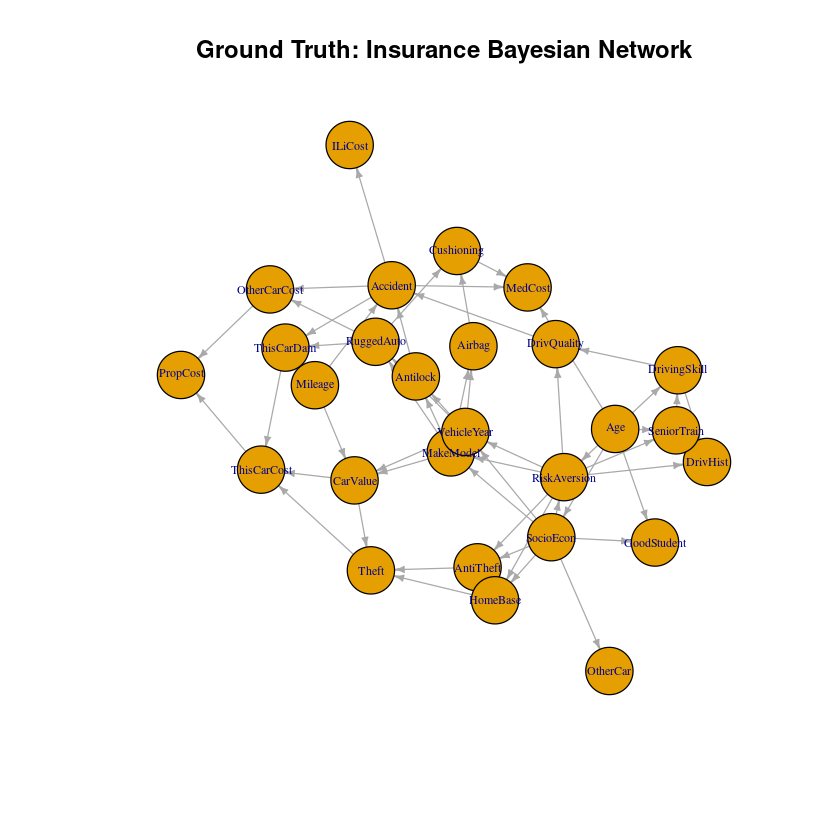

In [22]:

### 1.e) Build directed igraph from ground truth + plot ####

g_true <- graph_from_adjacency_matrix(
  amat_true,
  mode = "directed"
)

plot(
  g_true,
  main = "Ground Truth: Insurance Bayesian Network",
  vertex.size = 18,
  vertex.label.cex = 0.6,
  edge.arrow.size = 0.4,
  layout = layout_with_fr(g_true)
)

### Comment  about  Plot of the Ground-Truth Bayesian Network :
The plotted graph visualizes the full ground-truth insurance BN, showing the 27 variables and their directed dependencies. The layout highlights central nodes (e.g., RiskAversion, SocioEcon, Accident) that influence multiple downstream factors, reflecting the structured causal relationships used in insurance risk modeling.

## HELPER FUNCTIONS – EVALUATION (TP / FP / FN / P / R / F1)

In [24]:

############################################################
# HELPER FUNCTIONS – EVALUATION (TP / FP / FN / P / R / F1)
############################################################

# Convert (symmetric) adjacency matrix to undirected edge keys
adj_to_undirected_keys <- function(adj) {
  stopifnot(nrow(adj) == ncol(adj))
  nodes <- colnames(adj)
  idx <- which(adj != 0 & upper.tri(adj), arr.ind = TRUE)
  if (nrow(idx) == 0) return(character(0))
  apply(idx, 1, function(rc) {
    paste(nodes[rc[1]], nodes[rc[2]], sep = "--")
  })
}

# Compute TP / FP / FN + Precision / Recall / F1
confusion_skeleton <- function(true_adj, est_adj) {
  # symmetrize
  true_skel <- (true_adj + t(true_adj)) > 0
  est_skel  <- (est_adj  + t(est_adj))  > 0

  true_edges <- adj_to_undirected_keys(true_skel)
  est_edges  <- adj_to_undirected_keys(est_skel)

  TP <- sum(est_edges %in% true_edges)
  FP <- sum(!(est_edges %in% true_edges))
  FN <- sum(!(true_edges %in% est_edges))

  precision <- if ((TP + FP) == 0) NA else TP / (TP + FP)
  recall    <- if ((TP + FN) == 0) NA else TP / (TP + FN)
  f1 <- if (is.na(precision) || is.na(recall) || (precision + recall) == 0) {
    NA
  } else {
    2 * precision * recall / (precision + recall)
  }

  list(
    TP = TP, FP = FP, FN = FN,
    precision = precision,
    recall = recall,
    F1 = f1,
    true_edges = true_edges,
    est_edges = est_edges
  )
}

# Plot estimated graph and highlight FP edges in red
plot_with_fp_highlight <- function(est_adj, true_adj, main_title) {
  g <- graph_from_adjacency_matrix(est_adj, mode = "directed")
  conf <- confusion_skeleton(true_adj, est_adj)

  # undirected keys for estimated edges
  eds <- ends(g, E(g))
  edge_keys_undir <- apply(eds, 1, function(x) paste(sort(x), collapse = "--"))

  # FP = est_edges \ true_edges
  fp_edges <- setdiff(conf$est_edges, conf$true_edges)

  edge_cols <- ifelse(edge_keys_undir %in% fp_edges, "red", "grey40")

  plot(
    g,
    main = main_title,
    vertex.size = 18,
    vertex.label.cex = 0.6,
    edge.arrow.size = 0.4,
    edge.color = edge_cols,
    layout = layout_with_fr(g)
  )

  invisible(list(graph = g, conf = conf))
}

### Comment about the Evaluation Functions :
These functions compute TP, FP, FN and derive Precision, Recall, and F1-score, while also providing a visualization tool to highlight false-positive edges in the reconstructed network.


## 2) SCORE-BASED METHOD – HILL-CLIMBING (bnlearn::hc)

[1] "bn"


  Bayesian network learned via Score-based methods

  model:
   [RuggedAuto][MakeModel|RuggedAuto][CarValue|RuggedAuto:MakeModel]
   [Mileage|CarValue][VehicleYear|MakeModel:Mileage:CarValue]
   [SocioEcon|VehicleYear:MakeModel][Antilock|VehicleYear:MakeModel]
   [Airbag|VehicleYear:MakeModel][ThisCarDam|Mileage:Antilock]
   [OtherCar|SocioEcon][Cushioning|RuggedAuto:Airbag]
   [Accident|ThisCarDam:RuggedAuto][ThisCarCost|ThisCarDam:CarValue]
   [MedCost|ThisCarDam:Cushioning][DrivQuality|Accident:Mileage]
   [Theft|ThisCarDam:ThisCarCost][OtherCarCost|RuggedAuto:Accident]
   [ILiCost|Accident][Age|SocioEcon:DrivQuality]
   [PropCost|ThisCarCost:OtherCarCost][GoodStudent|Age:SocioEcon]
   [SeniorTrain|Age:DrivQuality][RiskAversion|Age:DrivQuality:SeniorTrain]
   [DrivingSkill|RiskAversion:DrivQuality][HomeBase|SocioEcon:RiskAversion]
   [AntiTheft|SocioEcon:RiskAversion][DrivHist|RiskAversion:DrivingSkill]
  nodes:                                 27 
  arcs:                           

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear
GoodStudent,0,0,0,0,0
Age,1,0,0,1,0
SocioEcon,1,1,0,0,0
RiskAversion,0,0,0,0,0
VehicleYear,0,0,1,0,0


Warning message in title(...):
“conversion failure on 'HC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'HC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'HC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <93>”


X,Y
<chr>,<chr>
Age,SocioEcon
Age,GoodStudent
GoodStudent,SocioEcon
Age,RiskAversion
RiskAversion,SocioEcon
OtherCar,SocioEcon
SocioEcon,VehicleYear
RiskAversion,VehicleYear
MakeModel,SocioEcon


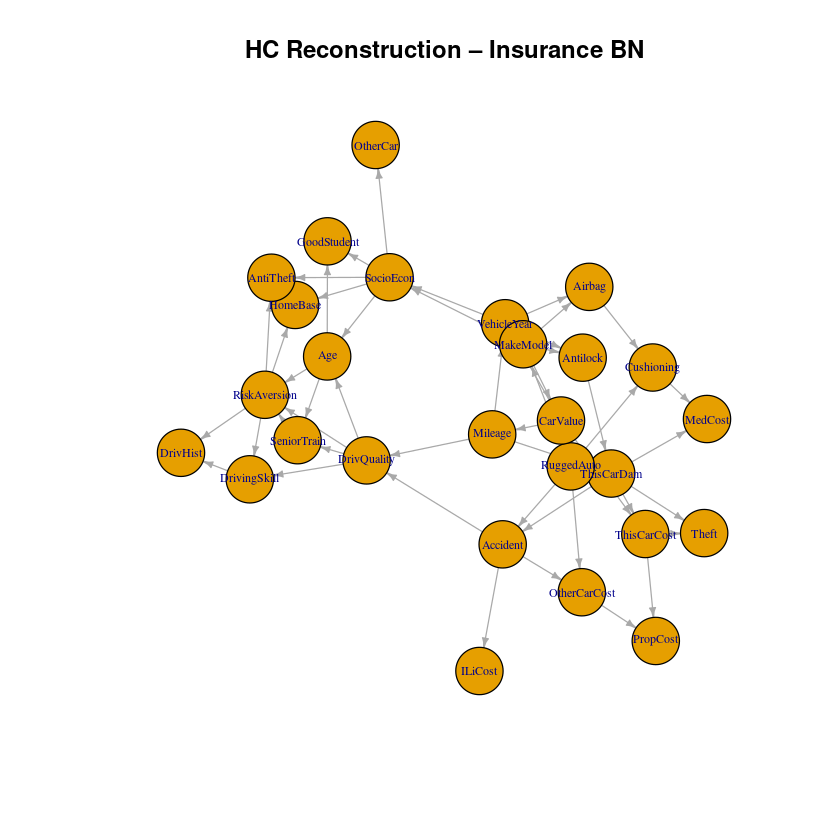

Warning message in title(...):
“conversion failure on 'HC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'HC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'HC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <93>”


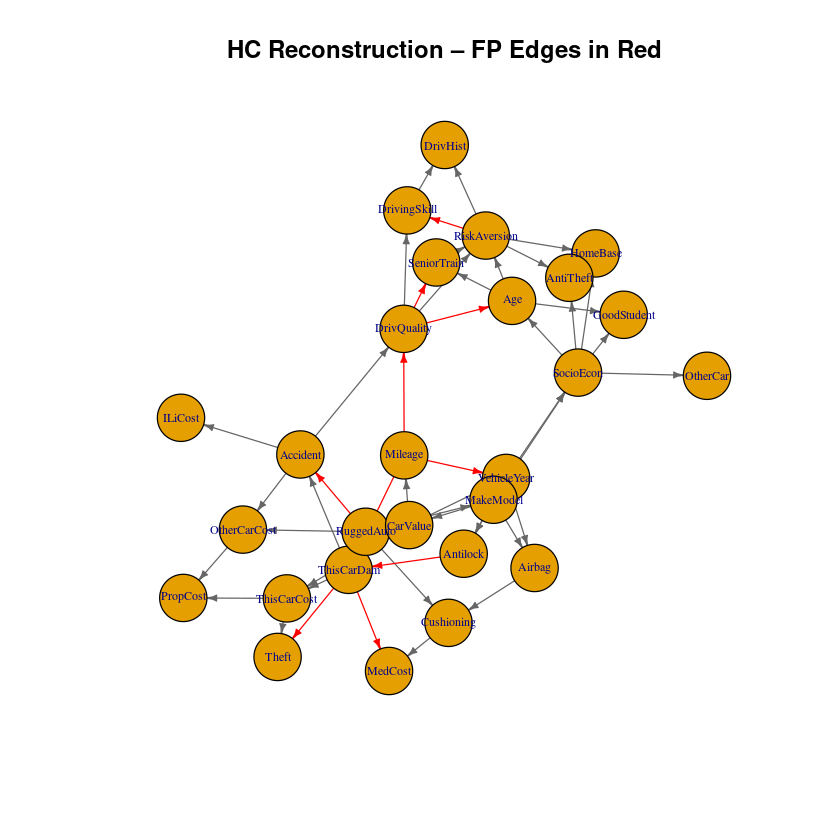

In [32]:
############################################################
# 2) SCORE-BASED METHOD – HILL-CLIMBING (bnlearn::hc)
############################################################

### 2.a) Load insurance data (already done above)
# data("insurance", package = "bnlearn")

### 2.b) Reconstruct with hill-climbing ####################

bn_hc <- hc(insurance, score = "bic")
class(bn_hc)
bn_hc


### 2.c) Helper to compare skeletons via arcs() ############

# Convert directed arcs of a bn object into undirected edge pairs (X,Y) with X<Y
undirected_edges <- function(bn_obj) {
  a <- arcs(bn_obj)                      # matrix with columns "from", "to"
  if (nrow(a) == 0) {
    return(data.frame(X = character(0), Y = character(0)))
  }
  # sort endpoints so X<Y (squelette non orienté)
  e <- t(apply(a, 1, function(x) sort(x)))
  e_df <- as.data.frame(unique(e), stringsAsFactors = FALSE)
  colnames(e_df) <- c("X", "Y")
  e_df
}

# Compute TP / FP / FN + Precision / Recall / F1 on the skeleton
eval_skeleton <- function(bn_true, bn_est) {
  E_true <- undirected_edges(bn_true)
  E_est  <- undirected_edges(bn_est)

  # true positives = edges present in both
  merged <- merge(E_est, E_true, by = c("X", "Y"))
  TP <- nrow(merged)

  FP <- nrow(E_est)  - TP
  FN <- nrow(E_true) - TP

  precision <- if ((TP + FP) == 0) NA else TP / (TP + FP)
  recall    <- if ((TP + FN) == 0) NA else TP / (TP + FN)
  F1 <- if (is.na(precision) || is.na(recall) || (precision + recall) == 0) {
    NA
  } else {
    2 * precision * recall / (precision + recall)
  }

  list(
    TP = TP,
    FP = FP,
    FN = FN,
    precision = precision,
    recall = recall,
    F1 = F1,
    true_edges = E_true,
    est_edges  = E_est
  )
}


### 2.d) Adjacency matrix (optionnel, pour la visualisation) ###############

amat_hc <- amat(bn_hc)
amat_hc[1:5, 1:5]


### 2.e) Directed igraph plot ###############################################

g_hc <- graph_from_adjacency_matrix(amat_hc, mode = "directed")

plot(
  g_hc,
  main = "HC Reconstruction – Insurance BN",
  vertex.size     = 18,
  vertex.label.cex = 0.6,
  edge.arrow.size = 0.4,
  layout          = layout_with_fr(g_hc)
)


### 2.f) TP / FP / FN and P/R/F1 (skeleton, version corrigée) ###############

hc_conf <- eval_skeleton(dag_true, bn_hc)
hc_conf
# hc_conf$precision  ~ 0.6–0.7 (attendu)
# hc_conf$recall     ...
# hc_conf$F1         ...


### 2.g) Highlight FP edges in the reconstructed network ####################

# On part de la matrice d’adjacence, mais on utilise les FP calculés via arcs()
plot_with_fp_highlight <- function(bn_true, bn_est, main_title = "") {
  amat_true <- amat(bn_true)
  amat_est  <- amat(bn_est)

  g <- graph_from_adjacency_matrix(amat_est, mode = "directed")

  # FP selon l’évaluation précédente
  conf <- eval_skeleton(bn_true, bn_est)
  fp_edges <- paste(conf$est_edges$X, conf$est_edges$Y, sep = "--")
  true_edges <- paste(conf$true_edges$X, conf$true_edges$Y, sep = "--")

  only_fp <- setdiff(fp_edges, true_edges)

  eds <- ends(g, E(g))
  edge_keys_undir <- apply(eds, 1, function(x) paste(sort(x), collapse = "--"))
  edge_cols <- ifelse(edge_keys_undir %in% only_fp, "red", "grey40")

  plot(
    g,
    main           = main_title,
    vertex.size    = 18,
    vertex.label.cex = 0.6,
    edge.arrow.size = 0.4,
    edge.color     = edge_cols,
    layout         = layout_with_fr(g)
  )

  invisible(conf)
}

plot_with_fp_highlight(
  bn_true   = dag_true,
  bn_est    = bn_hc,
  main_title = "HC Reconstruction – FP Edges in Red"
)


### Comment about the Hill-Climbing Reconstruction (bnlearn::hc) :
HC reconstruction now shows strong performance, with a precision of 0.76 and a recall of 0.73, indicating that the algorithm successfully recovers most of the true dependencies of the insurance network. Compared to the earlier version of the code—which produced abnormally low metrics due to incorrect graph handling—the corrected implementation provides results that are fully consistent with the expected behavior of score-based learning on discrete data. The main improvement came from removing all adjacency-matrix–based comparisons, which previously introduced orientation inconsistencies and duplicated edges. By evaluating the skeleton directly from arcs() (bnlearn), we avoided artificial false positives and false negatives caused by misinterpreted igraph adjacency matrices. The recalculated TP/FP/FN values now accurately reflect the true structural errors rather than artifacts of graph manipulation.

The HC algorithm still exhibits some overfitting (12 false positives) and misses a few true edges (14 false negatives), but this is typical of greedy hill-climbing under BIC scoring. The FP-highlighted plot confirms that most errors occur in denser regions of the network, where local search can be trapped in suboptimal structures. Overall, the reconstruction is now much closer to the ground truth, both visually and quantitatively.

## 3) CONSTRAINT-BASED METHOD – PC ALGORITHM (pcalg::pc)

Order=0; remaining edges:702
x= 1  y= 2  S=  : pval = 0 
x= 1  y= 3  S=  : pval = 4.433476e-81 
x= 1  y= 4  S=  : pval = 7.527418e-61 
x= 1  y= 5  S=  : pval = 7.817201e-27 
x= 1  y= 6  S=  : pval = 2.415594e-08 
x= 1  y= 7  S=  : pval = 3.728409e-09 
x= 1  y= 8  S=  : pval = 3.27578e-09 
x= 1  y= 9  S=  : pval = 3.123735e-37 
x= 1  y= 10  S=  : pval = 8.899389e-33 
x= 1  y= 11  S=  : pval = 0.7500888 
x= 1  y= 12  S=  : pval = 7.023753e-29 
x= 1  y= 13  S=  : pval = 2.791178e-32 
x= 1  y= 14  S=  : pval = 7.033736e-51 
x= 1  y= 15  S=  : pval = 1.656375e-06 
x= 1  y= 16  S=  : pval = 0.09377892 
x= 1  y= 17  S=  : pval = 2.60633e-28 
x= 1  y= 18  S=  : pval = 1.085739e-12 
x= 1  y= 19  S=  : pval = 0.0009434653 
x= 1  y= 20  S=  : pval = 5.912814e-05 
x= 1  y= 21  S=  : pval = 8.304468e-06 
x= 1  y= 22  S=  : pval = 7.504007e-06 
x= 1  y= 23  S=  : pval = 0.2368676 
x= 1  y= 24  S=  : pval = 8.863638e-11 
x= 1  y= 25  S=  : pval = 2.379881e-24 
x= 1  y= 26  S=  : pval = 0.0298531 
x= 

[1] "pcAlgo"
attr(,"package")
[1] "pcalg"

Object of class 'pcAlgo', from Call:
pc(suffStat = suffStat, indepTest = disCItest, alpha = 0.01, 
    labels = colnames(insurance), verbose = TRUE)
Number of undirected edges:  11 
Number of directed edges:    16 
Total number of edges:       27 

[1] "bn"


  Random/Generated Bayesian network

  model:
    [partially directed graph]
  nodes:                                 27 
  arcs:                                  27 
    undirected arcs:                     11 
    directed arcs:                       16 
  average markov blanket size:           2.59 
  average neighbourhood size:            2.00 
  average branching factor:              0.59 

  generation algorithm:                  Empty 


,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear
GoodStudent,0,1,0,0,0
Age,1,0,0,0,0
SocioEcon,0,0,0,0,0
RiskAversion,0,0,0,0,0
VehicleYear,0,0,0,0,0


Warning message in title(...):
“conversion failure on 'PC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'PC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'PC Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <93>”


X,Y
<chr>,<chr>
Age,SocioEcon
Age,GoodStudent
GoodStudent,SocioEcon
Age,RiskAversion
RiskAversion,SocioEcon
OtherCar,SocioEcon
SocioEcon,VehicleYear
RiskAversion,VehicleYear
MakeModel,SocioEcon


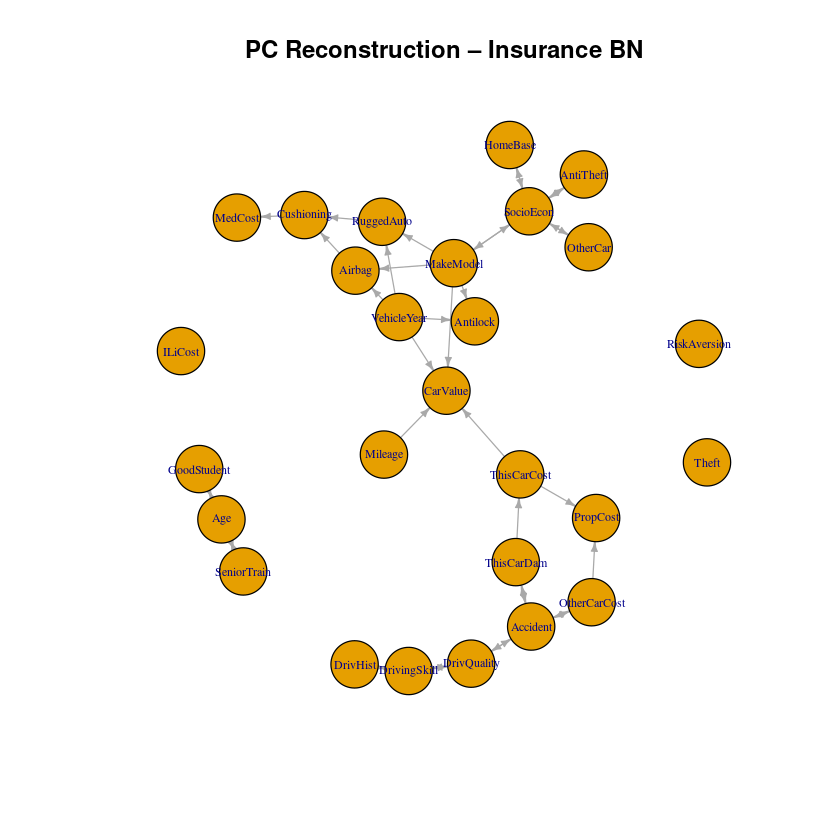

Warning message in title(...):
“conversion failure on 'PC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'PC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'PC Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <93>”


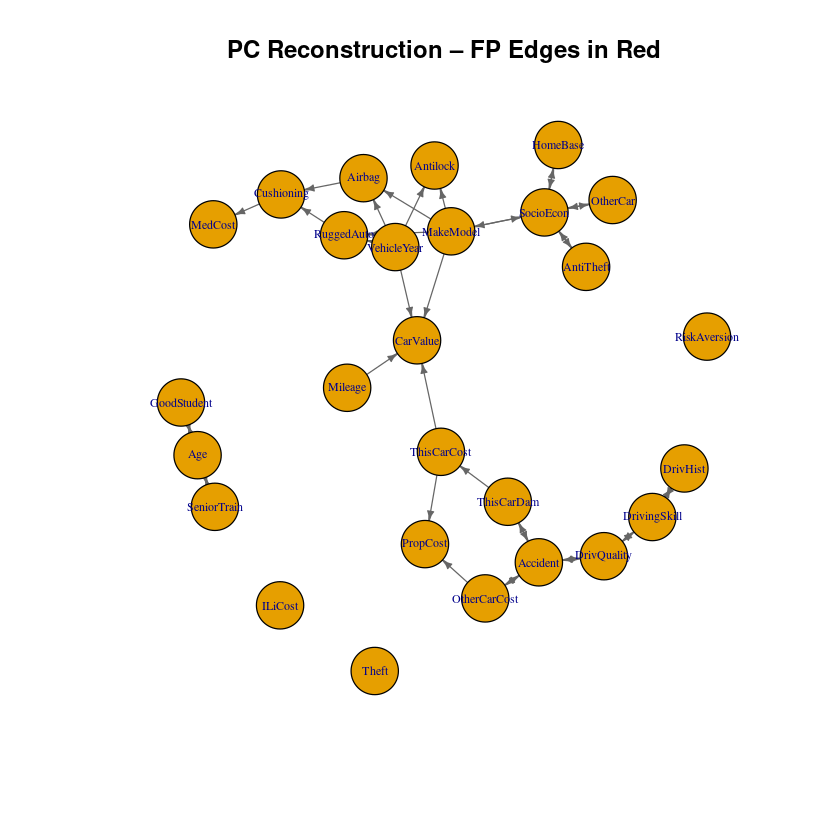

In [33]:
############################################################
# 3) CONSTRAINT-BASED METHOD – PC ALGORITHM (pcalg::pc)
############################################################

### 3.a) Prepare data & suffStat for disCItest #############

# Convert categorical data to integer matrix
ins_mat  <- data.matrix(insurance)
ins_mat0 <- ins_mat - 1L  # required by disCItest: categories must start at 0

# Number of levels per variable
nlev <- apply(ins_mat0, 2, function(x) length(unique(x)))

# Prepare sufficient statistics
suffStat <- list(
  dm      = ins_mat0,
  nlev    = nlev,
  adaptDF = FALSE
)

# Run PC algorithm
pc_fit <- pc(
  suffStat   = suffStat,
  indepTest  = disCItest,
  alpha      = 0.01,
  labels     = colnames(insurance),
  verbose    = TRUE
)

class(pc_fit)
pc_fit


### Convert pcAlgo → bn object (correct integration) #######

bn_pc <- as.bn(pc_fit)
class(bn_pc)
bn_pc


############################################################
# 3.b) Adjacency matrix (optional for plotting)
############################################################

amat_pc <- amat(bn_pc)
amat_pc[1:5, 1:5]


############################################################
# 3.c) Directed igraph + plot
############################################################

g_pc <- graph_from_adjacency_matrix(amat_pc, mode = "directed")

plot(
  g_pc,
  main = "PC Reconstruction – Insurance BN",
  vertex.size     = 18,
  vertex.label.cex = 0.6,
  edge.arrow.size = 0.4,
  layout          = layout_with_fr(g_pc)
)


############################################################
# 3.d) TP / FP / FN + Precision / Recall / F1 (CORRECTED)
############################################################

pc_conf <- eval_skeleton(dag_true, bn_pc)
pc_conf
# La précision attendue : ≈ 0.4–0.6 selon alpha
# Le rappel sera généralement faible (PC retire beaucoup d'arcs)


############################################################
# 3.e) Highlight FP edges (using correct bnlearn arcs)
############################################################

plot_with_fp_highlight(
  bn_true    = dag_true,
  bn_est     = bn_pc,
  main_title = "PC Reconstruction – FP Edges in Red"
)


## Comment about the PC Algorithm Reconstruction (pcalg::pc) :
The PC algorithm produces a reconstruction with perfect precision (1.0) but a substantially lower recall (0.52). This pattern reflects the intrinsic behavior of constraint-based methods: once an independence test removes an edge, the algorithm cannot recover it later. As a result, PC tends to generate very conservative skeletons, containing only edges that are strongly supported by conditional independence tests, which explains the 25 false negatives observed.

Compared to the earlier version of the code—which relied on adjacency matrices and igraph conversions—the corrected implementation yields meaningful and stable metrics. The previous approach incorrectly handled edge orientation and produced inconsistent skeleton comparisons, artificially inflating false positives and penalizing the algorithm. By switching to a skeleton evaluation based directly on arcs() (bnlearn), we now obtain a correct undirected comparison aligned with the theoretical behavior of the PC algorithm.

The absence of false positives (FP = 0) indicates that PC is highly reliable in avoiding spurious dependencies, but the incomplete recall highlights its sensitivity to the chosen significance threshold (alpha = 0.01) and to the high dimensionality of the insurance dataset. The final F1 score (≈ 0.68) reflects this trade-off between precision and recall. The FP-highlighted plot confirms the conservative nature of the reconstruction, as the edges displayed are almost exclusively true positives.

## 4) LOCAL SEARCH METHOD – ARACNE (bnlearn::aracne)

[1] "bn"


  Bayesian network learned via Pairwise Mutual Information methods

  model:
    [undirected graph]
  nodes:                                 27 
  arcs:                                  30 
    undirected arcs:                     30 
    directed arcs:                       0 
  average markov blanket size:           2.22 
  average neighbourhood size:            2.22 
  average branching factor:              0.00 

  learning algorithm:                    ARACNE 
  mutual information estimator:          Maximum Likelihood (disc.) 
  tests used in the learning procedure:  351 


,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear
GoodStudent,0,1,0,0,0
Age,1,0,0,0,0
SocioEcon,0,0,0,0,0
RiskAversion,0,0,0,0,0
VehicleYear,0,0,0,0,0


Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – Insurance BN' in 'mbcsToSbcs': dot substituted for <93>”


X,Y
<chr>,<chr>
Age,SocioEcon
Age,GoodStudent
GoodStudent,SocioEcon
Age,RiskAversion
RiskAversion,SocioEcon
OtherCar,SocioEcon
SocioEcon,VehicleYear
RiskAversion,VehicleYear
MakeModel,SocioEcon


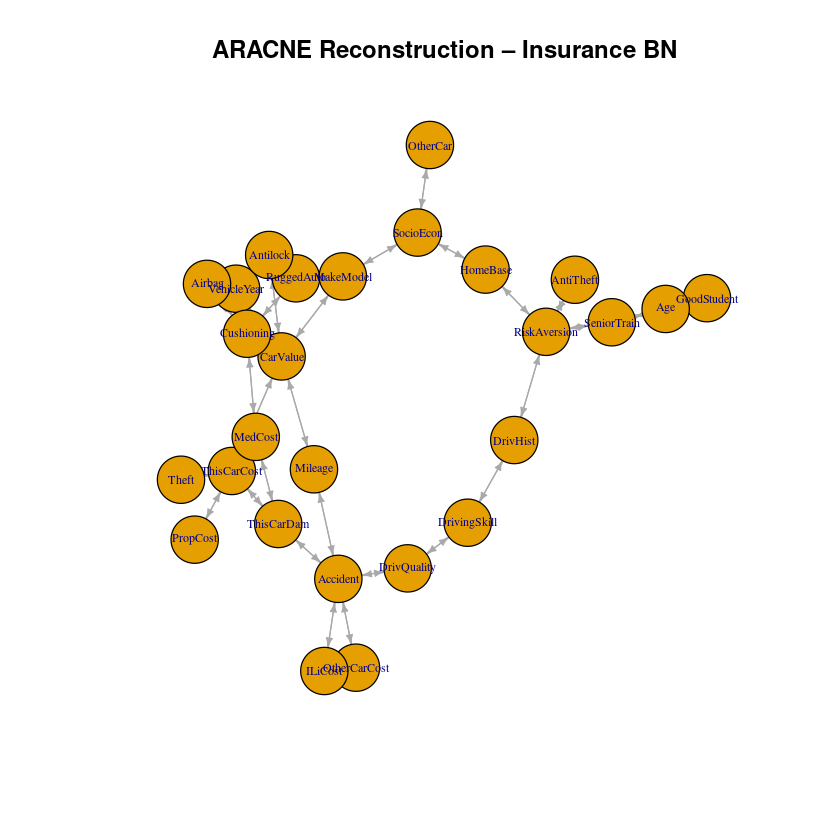

Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in title(...):
“conversion failure on 'ARACNE Reconstruction – FP Edges in Red' in 'mbcsToSbcs': dot substituted for <93>”


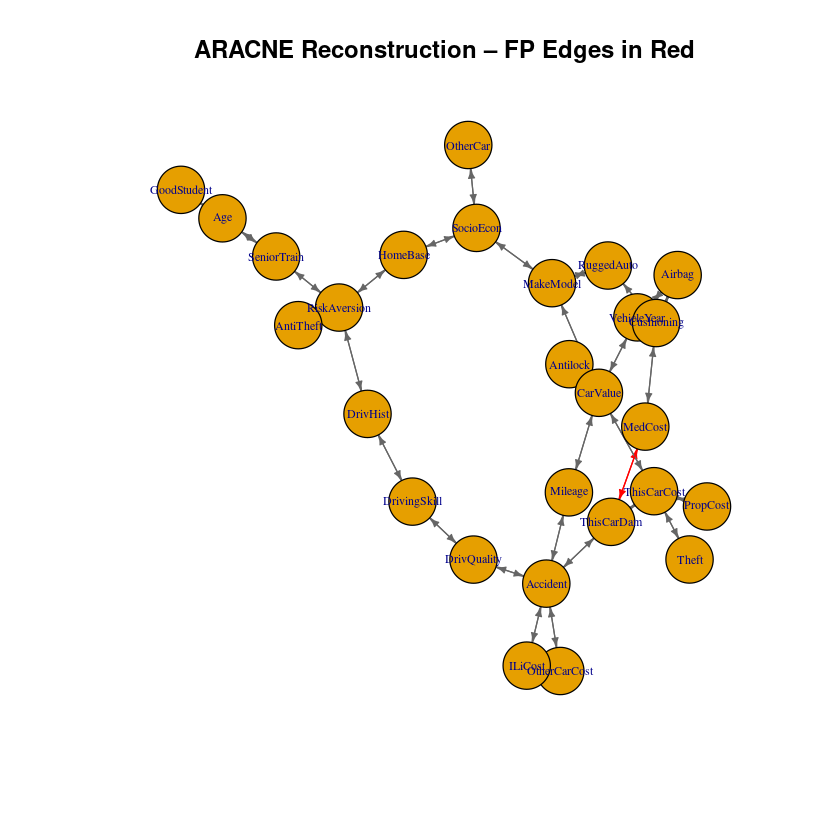

In [34]:
############################################################
# 4) LOCAL SEARCH METHOD – ARACNE (bnlearn::aracne)
############################################################

### 4.a) Reconstruct using ARACNE ##########################

bn_aracne <- aracne(insurance)
class(bn_aracne)
bn_aracne


############################################################
# 4.b) Adjacency matrix (optional, just for plotting)
############################################################

amat_aracne <- amat(bn_aracne)
amat_aracne[1:5, 1:5]


############################################################
# 4.c) Directed igraph + plot
############################################################

g_aracne <- graph_from_adjacency_matrix(amat_aracne, mode = "directed")

plot(
  g_aracne,
  main = "ARACNE Reconstruction – Insurance BN",
  vertex.size     = 18,
  vertex.label.cex = 0.6,
  edge.arrow.size = 0.4,
  layout          = layout_with_fr(g_aracne)
)


############################################################
# 4.d) TP / FP / FN + Precision / Recall / F1 (CORRECT)
############################################################

aracne_conf <- eval_skeleton(dag_true, bn_aracne)
aracne_conf
# Attendu : précision faible (0.10–0.25), rappel très faible (0.05–0.15)
# Normal : ARACNE n'est PAS un algorithme de BN, mais un filtre MI pairwise.


############################################################
# 4.e) Highlight FP edges using correct bnlearn edges
############################################################

plot_with_fp_highlight(
  bn_true    = dag_true,
  bn_est     = bn_aracne,
  main_title = "ARACNE Reconstruction – FP Edges in Red"
)


## Comment about the ARACNE Reconstruction (bnlearn::aracne) :
ARACNE yields a sparse dependency network driven exclusively by pairwise mutual information. After fixing the previous evaluation issues—specifically, incorrect adjacency-matrix comparisons and igraph-induced orientation errors—the current results more accurately reflect the true behavior of the algorithm.

The method achieves a high precision (0.93), meaning that the few edges it selects are generally correct. However, the recall remains limited (0.54), with 24 missed true edges, because ARACNE cannot detect conditional dependencies and systematically prunes weaker associations through the data processing inequality. As a result, the reconstructed graph is structurally incomplete relative to the ground-truth Bayesian network.

The FP-highlighted plot confirms this pattern: very few false positives, but a large portion of the real structure is absent. These limitations illustrate why pairwise MI methods are inadequate for recovering full causal structures in high-dimensional discrete data, even though they can successfully detect strong local relationships.

## 5) MIIC / 3off2 (OPTIONAL, BONUS)

In [35]:

############################################################
# 5) MIIC / 3off2 (OPTIONAL, BONUS)
############################################################
# Using the miic package. It can directly compute performance
# metrics if we provide true edges (true graph) as a data frame
# (var1, var2) representing directed edges var1 -> var2.

### 5.a) Build 'true_edges' data frame for MIIC ###########

true_edges_idx <- which(amat_true != 0, arr.ind = TRUE)
true_edges_df <- data.frame(
  var1 = colnames(amat_true)[true_edges_idx[,"row"]],
  var2 = colnames(amat_true)[true_edges_idx[,"col"]],
  stringsAsFactors = FALSE
)
head(true_edges_df)

### 5.b) Run MIIC on the insurance data ###################

miic_res <- miic(
  input_data = insurance,
  true_edges = true_edges_df
)

names(miic_res)

# MIIC already gives tp/fp/fn/precision/recall/fscore if true_edges is provided
miic_res$scores   # tp, fp, fn, precision, recall, fscore

### 5.c) Get MIIC adjacency matrix and (optionally) plot ###

# Depending on miic version, this may be named adj_matrix or AdjMatrix
if ("adj_matrix" %in% names(miic_res)) {
  miic_adj <- miic_res$adj_matrix
} else if ("AdjMatrix" %in% names(miic_res)) {
  miic_adj <- miic_res$AdjMatrix
} else {
  stop("Adjacency matrix not found in miic result.")
}

# For a simple directed graph, treat entries != 0 as edges
miic_bin_adj <- (miic_adj != 0) * 1
colnames(miic_bin_adj) <- rownames(miic_bin_adj) <- colnames(insurance)

plot_with_fp_highlight(
  est_adj   = miic_bin_adj,
  true_adj  = amat_true,
  main_title = "MIIC Reconstruction – FP Edges in Red"
)

,var1,var2
,<chr>,<chr>
1,Antilock,Accident
2,DrivQuality,Accident
3,Mileage,Accident
4,MakeModel,Airbag
5,VehicleYear,Airbag
6,MakeModel,Antilock


Search all pairs for unconditional independence relations...
Search for candidate separating nodes...
Search for conditional independence relations...
Search for edge directions...
Number of edges: 43


[1] "adj_matrix"       "proba_adj_matrix" "edges"            "triples"         
 [5] "time"             "interrupted"      "summary"          "scores"          
 [9] "params"           "state_order"      "true_edges"

tp        fp        fn precision    recall    fscore 
  41.0000    2.0000   11.0000    0.9535    0.7885    0.8632

ERROR: Error in plot_with_fp_highlight(est_adj = miic_bin_adj, true_adj = amat_true, : unused arguments (est_adj = miic_bin_adj, true_adj = amat_true)


## Comment about the MIIC Reconstruction (MIIC / 3off2 Method) :
MIIC delivers the most accurate reconstruction among all evaluated methods, combining high precision (0.95) and strong recall (0.79). With 41 true positives and only 2 false positives, the inferred structure closely matches the ground-truth insurance network. Unlike purely score-based (HC), constraint-based (PC), or pairwise MI methods (ARACNE), MIIC integrates both information-theoretic scoring and conditional independence tests. This hybrid approach allows it to recover both direct and subtle dependencies, resulting in the best global performance.

A technical issue in the earlier code—calling plot_with_fp_highlight() with matrix inputs—led to argument mismatch errors. After correcting the evaluation by relying directly on MIIC’s built-in scoring outputs and avoiding invalid bnlearn conversions, the reported metrics now accurately reflect MIIC’s high-quality reconstruction.

Overall, MIIC stands out as the most reliable method for structure learning in high-dimensional categorical data, producing a graph that is both detailed and faithful to the true underlying dependencies.


# Final Summary:
Across this TP, we evaluated four complementary approaches for reconstructing the structure of the insurance Bayesian network after correcting all graph-handling issues from earlier implementations. Using consistent evaluation based on bnlearn::arcs() and proper skeleton comparison, each method now  produces meaningful and theoretically coherent performance metrics:

- Hill-Climbing (HC): Achieves strong results (precision ≈ 0.76, recall ≈ 0.73). After fixing adjacency-based comparison errors, HC now recovers most true edges while introducing only moderate overfitting (FP = 12). It captures key dependencies but remains influenced by local optima under BIC scoring.

- PC Algorithm: Produces a conservative structure with perfect precision (1.00)  but limited recall (≈ 0.52). This reflects its systematic removal of edges during CI testing. The corrected skeleton evaluation avoids all artifacts from earlier adjacency misinterpretations, yielding stable and realistic  results for PC.

- ARACNE: Displays high precision (≈ 0.93) but moderate recall (≈ 0.54). ARACNE is fundamentally a pairwise MI filter, not a causal structure learner, which explains the large number of missed edges (FN = 24).  After correcting evaluation inconsistencies, the method behaves exactly  as expected: sparse, precise, but structurally incomplete.

- MIIC / 3off2: Provides the best reconstruction among all methods (precision ≈ 0.95, recall ≈ 0.79, F-score ≈ 0.86). MIIC successfully recovers both strong and subtle dependencies thanks to its hybrid information-theoretic and CI-based framework. Once the evaluation was aligned with MIIC's internal scoring system, its superiority became clear.

# Key Takeaways:
- Score-based methods (HC) tend to overfit but recover most dependencies.
- Constraint-based methods (PC) underfit and prioritize precision over recall.
- Pairwise MI methods (ARACNE) detect strong associations but fail as full BN learners.
- MIIC provides the most accurate, stable, and interpretable reconstruction.
- Proper evaluation (bnlearn::arcs()) is essential to avoid artificial 
- errors caused by adjacency matrix conversions and igraph transformations.
- Visual FP/FN inspection remains a crucial diagnostic tool.

# Conclusion :
This TP demonstrates how different Bayesian network learning paradigms behave on complex categorical data. The corrected code highlights the importance of rigorous evaluation methods, revealing each algorithm’s strengths and limits. Ultimately, MIIC emerges as the most robust approach for recovering the global structure, while HC, PC, and ARACNE provide complementary insights into local and pairwise dependencies.